# CS-472 Computer Vision
## Assignment 05: Particle Swarm Optimization Tracking
## By: <span style="color:orange">Ioannis Kaziales</span> ~ csdp1305
### Spring semester 2022-2023 (Due Date: 03/07/2023)

This file contains a **demo for part B** (using PSO to track a white circle in a realistic background).
It contains in-depth visualization of the estimation process.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

from utils import *

np.random.seed(42)

After tinkering with different parameters (you can see the results in a video format), I decided to use the following parameters for the **Particle Swarm Optimization** algorithm. They achieved the best tradeoff between computational efficency, speed and accuracy.

In [2]:
in_dir = "askisi5_dataset2"
SAVE_IMGS: bool = False  # Set to True to save images to disk

if SAVE_IMGS:
    out_dir = "demos_output/partB"
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)

prefix = "colorFrame_0_"

# Testing on `dataset_2/frame_0`
Let's try to find the parameters of the circle for the frame 0.


### First, we load the image and plot the images with intermediate filtering steps

In [3]:
frame_num = 0
img = cv2.imread(os.path.join(in_dir, f"{prefix}{str(frame_num).zfill(5)}.jpg"))
img2 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
y_max, x_max = img2.shape[:2]
max_radius = min(x_max, y_max) / 2

If we can manage to remove the background, the task becomes easy (essentialy the same as the one in part A). So, we do our best to isolate the circle during the preprocessing, which includes:
- `thresholding the image` to make it binary (during actual estimation, start from a high threshold (200) and decrease it while the generated image is completely black)
- `applying closing morphological operation` to fill any blanks inside the circle
- `applying opening morphological operation` with a large kernel to remove the background (during estimation, the size is calculated using the estimated radius of the previous frame)
- `applying dilation` to restore the size of the circle (during `opening` it might have been eroded). This creates a clean mask
- `masking the 'closed' image`

The final image should be clean and contain only a circle

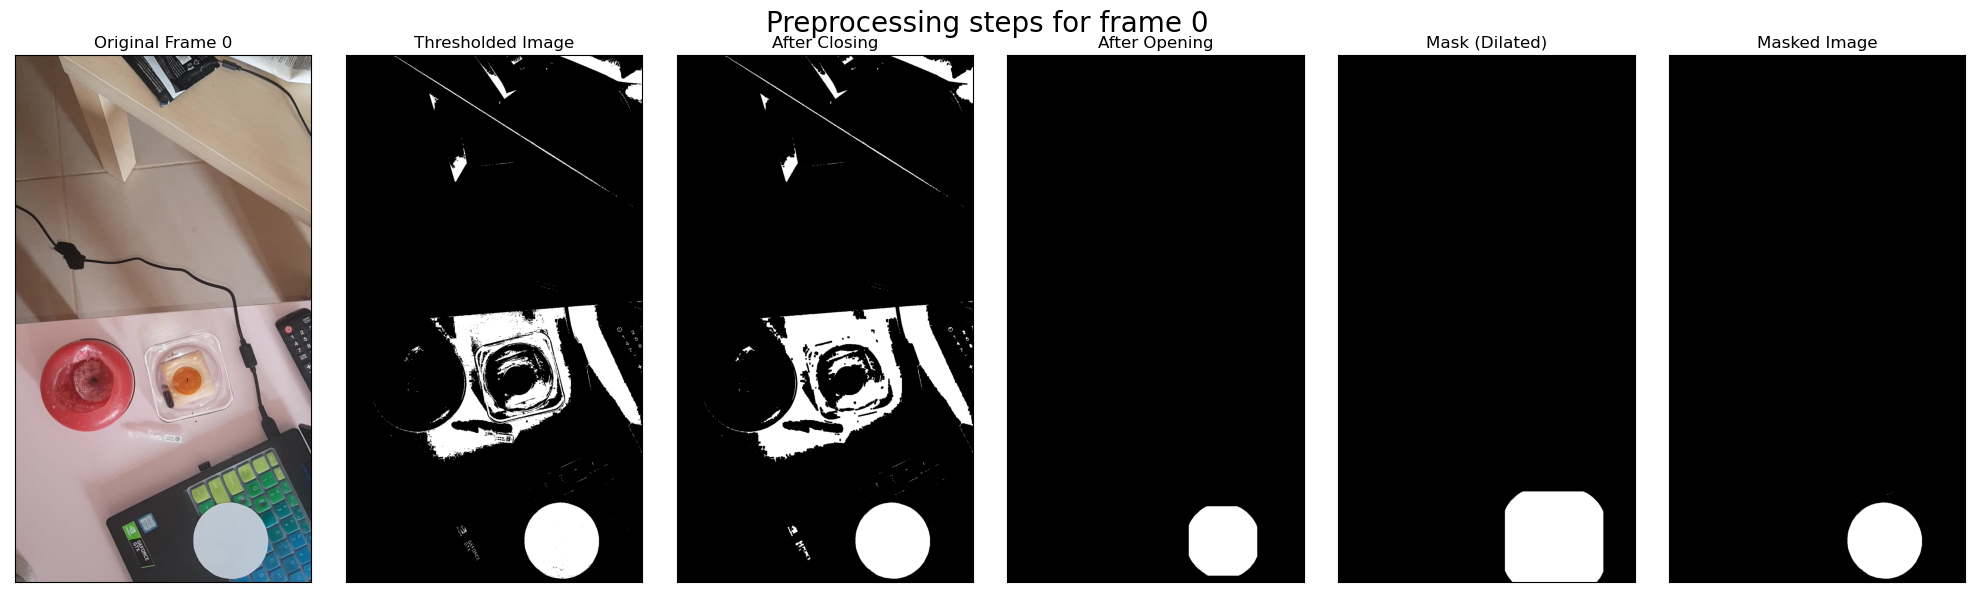

In [4]:
plt.figure(figsize=(20, 6))
# show original image
plt.subplot(1, 6, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title(f"Original Frame {frame_num}")
plt.xticks([])
plt.yticks([])
# apply threshold to get binary image
plt.subplot(1, 6, 2)
thresh = cv2.threshold(img2, 190, 255, cv2.THRESH_BINARY)[1]
plt.imshow(thresh, cmap="gray")
plt.title("Thresholded Image")
plt.xticks([])
plt.yticks([])
# apply closing to fill the circle
plt.subplot(1, 6, 3)
kernel = np.ones((5, 5), np.uint8)
closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
plt.imshow(closed, cmap="gray")
plt.title("After Closing")
plt.xticks([])
plt.yticks([])
plt.subplot(1, 6, 4)
# apply opening with big kernel to remove background noise
kernel = np.ones((110, 110), np.uint8)
opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel)
plt.imshow(opened, cmap="gray")
plt.title("After Opening")
plt.xticks([])
plt.yticks([])
# apply dilation to make the circle bigger (encompass the whole circle)
plt.subplot(1, 6, 5)
kernel = np.ones((110, 110), np.uint8)
mask = cv2.dilate(opened, kernel, iterations=1)
plt.imshow(mask, cmap="gray")
plt.title("Mask (Dilated)")
plt.xticks([])
plt.yticks([])
# apply mask to original image
plt.subplot(1, 6, 6)
img_preprocessed = cv2.bitwise_and(closed, closed, mask=mask)
plt.imshow(img_preprocessed, cmap="gray")
plt.title("Masked Image")
plt.xticks([])
plt.yticks([])

plt.suptitle(f"Preprocessing steps for frame {frame_num}", fontsize=20)
plt.tight_layout()
if SAVE_IMGS:
    plt.savefig(os.path.join(out_dir, f"frame{frame_num}_filtering_steps.png"))
plt.show()

### Let's run the PSO algorithm now
Since it is the first frame, we have no prior knowledge about the parameters of the circle

In [5]:
# PSO parameters for the first frame
num_particles = 20
max_iterations = 100
stop_iterations = 10    # stop if no improvement after 15 iterations
c1 = 2.0                # cognitive parameter
c2 = 2.0                # social parameter
w  = 0.7                # inertia weight
decay = 1.0             # decay of inertia


particles = initialize_particles(img_preprocessed, num_particles, [x_max, y_max, max_radius])
colors = np.random.rand(num_particles, 3)

optim = ParticleSwarmOptimizer(img_preprocessed, num_particles, max_iterations, c1, c2, w, decay, stop_iterations)
best_position, best_fitness, losses = optim.optimize(img_preprocessed, particles, [x_max, y_max, max_radius])

x, y, r = best_position

Let's check the estimated parameters now
$\to$ Success!

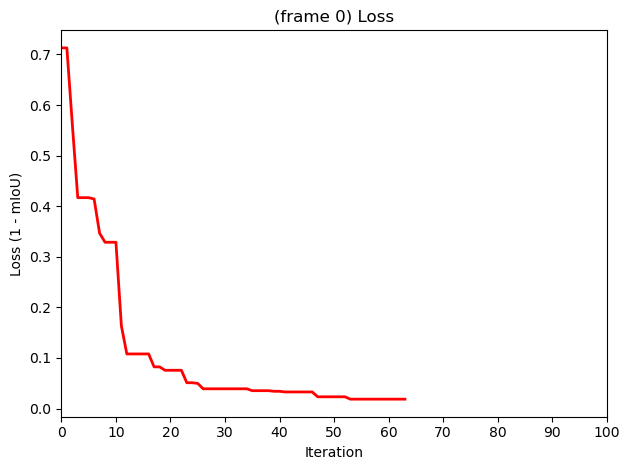

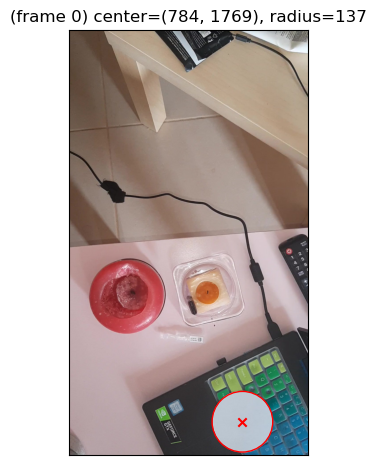

In [6]:
filename = os.path.join(out_dir, f'{prefix}{frame_num}_loss.png') if SAVE_IMGS else None
plot_loss(losses, title=f'(frame {frame_num}) Loss', max_iterations=max_iterations, save_filename=filename)

filename = os.path.join(out_dir, f'{prefix}{frame_num}_final.png') if SAVE_IMGS else None
title = f"(frame {frame_num}) center=({x}, {y}), radius={r}"
plot_estimation(img, best_position, title=title, save_filename=filename, rgb=True, est_type="circle")

## Next Frame
Now, let's estimate the parameters for the next frame. First, we load the image and initialize the particles randomly

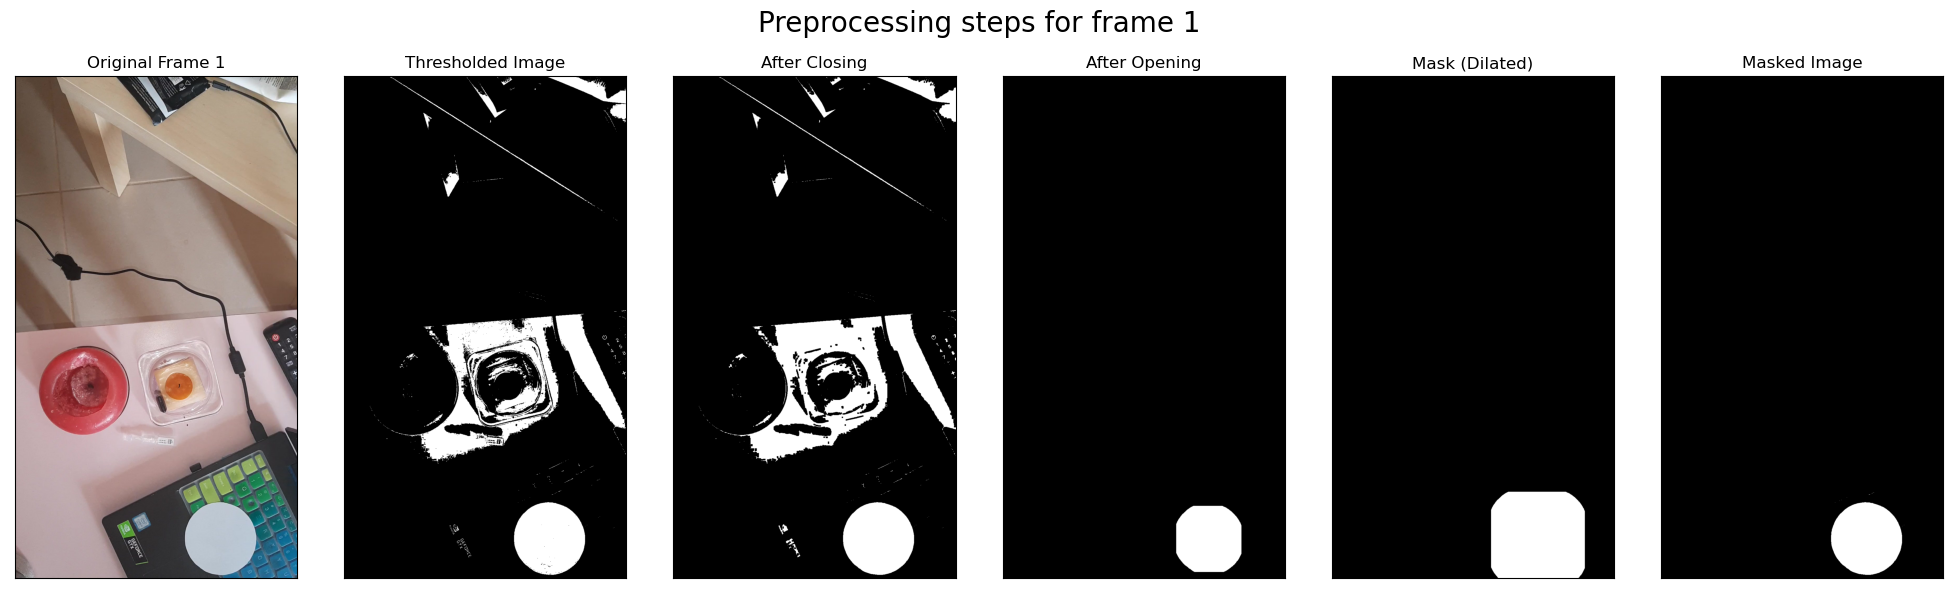

In [7]:
frame_num += 1
img = cv2.imread(os.path.join(in_dir, f"{prefix}{str(frame_num).zfill(5)}.jpg"))
img2 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
y_max, x_max = img2.shape[:2]
max_radius = min(x_max, y_max) / 2

plt.figure(figsize=(20, 6))
# show original image
plt.subplot(1, 6, 1)
#plt.imshow(img2, cmap="gray")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title(f"Original Frame {frame_num}")
plt.xticks([])
plt.yticks([])
# apply threshold to get binary image
plt.subplot(1, 6, 2)
thresh = cv2.threshold(img2, 190, 255, cv2.THRESH_BINARY)[1]
plt.imshow(thresh, cmap="gray")
plt.title("Thresholded Image")
plt.xticks([])
plt.yticks([])
# apply closing to fill the circle
plt.subplot(1, 6, 3)
kernel = np.ones((5, 5), np.uint8)
closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
plt.imshow(closed, cmap="gray")
plt.title("After Closing")
plt.xticks([])
plt.yticks([])
plt.subplot(1, 6, 4)
# apply opening with big kernel to remove background noise
kernel = np.ones((110, 110), np.uint8)
opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel)
plt.imshow(opened, cmap="gray")
plt.title("After Opening")
plt.xticks([])
plt.yticks([])
# apply dilation to make the circle bigger (encompass the whole circle)
plt.subplot(1, 6, 5)
kernel = np.ones((110, 110), np.uint8)
mask = cv2.dilate(opened, kernel, iterations=1)
plt.imshow(mask, cmap="gray")
plt.title("Mask (Dilated)")
plt.xticks([])
plt.yticks([])
# apply mask to original image
plt.subplot(1, 6, 6)
img_preprocessed = cv2.bitwise_and(closed, closed, mask=mask)
plt.imshow(img_preprocessed, cmap="gray")
plt.title("Masked Image")
plt.xticks([])
plt.yticks([])

plt.suptitle(f"Preprocessing steps for frame {frame_num}", fontsize=20)
plt.tight_layout()
plt.tight_layout()
if SAVE_IMGS:
    plt.savefig(os.path.join(out_dir, f"frame{frame_num}_filtering_steps.png"))
plt.show()

### Temporally Smooth Movement
Let's visualize the best global position found for the previous frame on the new frame:

We can observe that circles in successive image frames have similar parameters. We can utilize this observation as prior knowledge for each new frame, given that we have successfully identified the circle from the previous frame. Specifically, the previous best global position can serve as an estimate for the new position. In addition to that, we can modify the parameters to achieve faster convergence!

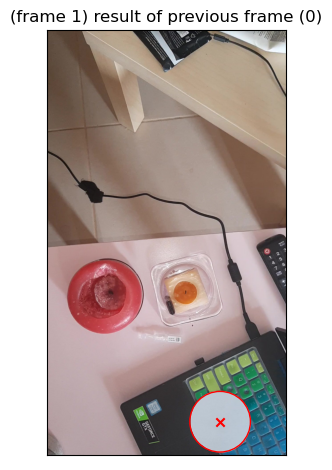

In [8]:
filename = os.path.join(out_dir, f'{prefix}{frame_num}_prev.png') if SAVE_IMGS else None
title = f"(frame {frame_num}) result of previous frame ({frame_num-1})"
plot_estimation(img, best_position, title=title, save_filename=filename, rgb=True, est_type="circle")

Let's run PSO for this frame using the prior knowledge

In [9]:
# PSO parameters for the other frames
num_particles = 20
max_iterations = 100
stop_iterations = 6    # stop if no improvement after 15 iterations
c1 = 0.4                # cognitive parameter
c2 = 1.0                # social parameter
w  = 0.7                # inertia weight
decay = 0.97             # decay of inertia


particles = initialize_particles(img_preprocessed, num_particles, [x_max, y_max, max_radius])
colors = np.random.rand(num_particles, 3)

optim = ParticleSwarmOptimizer(img_preprocessed, num_particles, max_iterations, c1, c2, w, decay, stop_iterations, best_position)
best_position, best_fitness, losses = optim.optimize(img_preprocessed, particles, [x_max, y_max, max_radius])

x, y, r = best_position

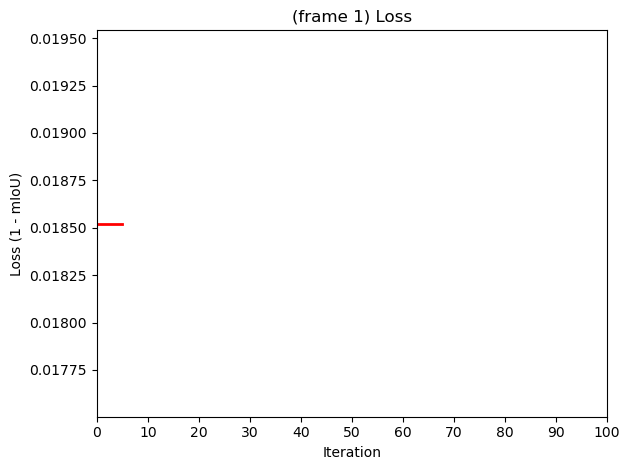

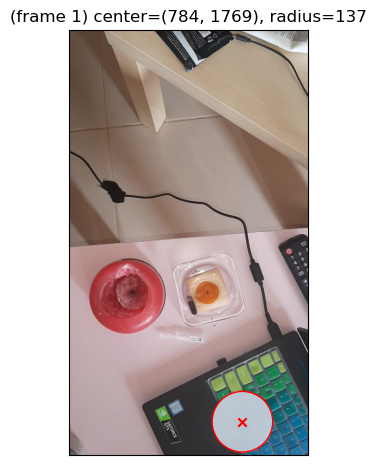

In [10]:
filename = os.path.join(out_dir, f'{prefix}{frame_num}_loss.png') if SAVE_IMGS else None
plot_loss(losses, title=f'(frame {frame_num}) Loss', max_iterations=max_iterations, save_filename=filename)

filename = os.path.join(out_dir, f'{prefix}{frame_num}_final.png') if SAVE_IMGS else None
title = f"(frame {frame_num}) center=({x}, {y}), radius={r}"
plot_estimation(img, best_position, title=title, save_filename=filename, rgb=True, est_type="circle")